In [28]:
import json
import numpy as np
import os
import cv2
import scipy.io as sio
import copy
import random
import tensorflow as tf
from glob import glob
from tqdm import tqdm
import sys
import math
#%matplotlib widget
# importing required libraries
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [29]:
root_path = "/home2/user/anders/3D"
train_params_300W = np.load(os.path.join(root_path, "/aidata/anders/objects/3D-head/300W/train_params.npy"))
test_params_300W = np.load(os.path.join(root_path, "/aidata/anders/objects/3D-head/300W/test_params.npy"))

train_params_AFLW = np.load(os.path.join(root_path, "/aidata/anders/objects/3D-head/AFLW2000/train_params.npy"))
test_params_AFLW = np.load(os.path.join(root_path, "/aidata/anders/objects/3D-head/AFLW2000/test_params.npy"))

train_params_LS = np.load(os.path.join(root_path, "/aidata/anders/objects/3D-head/LS3D-W/train_params.npy"))
test_params_LS = np.load(os.path.join(root_path, "/aidata/anders/objects/3D-head/LS3D-W/test_params.npy"))
params = np.concatenate([train_params_300W, test_params_300W, train_params_AFLW, test_params_AFLW, train_params_LS, test_params_LS], axis =0)

In [162]:
Rs = params[:, 1:10]
N, C = np.shape(Rs)
Rs = np.reshape(Rs, (N, 3, 3))
yaw = tf.math.asin(-Rs[..., 2, 0]) * (180 / np.pi)
pitch = tf.math.atan2(
            Rs[..., 2, 1] / tf.math.cos(yaw),
            Rs[..., 2, 2] / tf.math.cos(yaw)) * (180 / np.pi)
roll = tf.math.atan2(
    Rs[..., 1, 0] / tf.math.cos(yaw),
    Rs[..., 0, 0] / tf.math.cos(yaw)) * (180 / np.pi)
pitch = np.reshape(pitch, (-1))
pitch = np.where(pitch < 0., -(180 + pitch), (180 - pitch))
mask =  pitch < 100 
pitch = pitch[mask]
mask = pitch > -100
pitch = pitch[mask]

yaw = np.reshape(yaw, (-1))
roll = np.reshape(roll, (-1))
mask =  roll < 100 
roll = roll[mask]
mask = roll > -100
roll = roll[mask]

Text(0.5, 0, 'Pose angle')

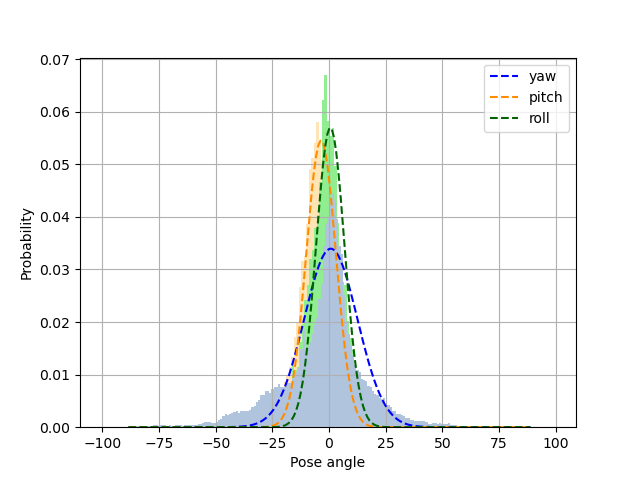

In [165]:

from scipy import optimize as op
def fitting_funs(bins, n):
    def f(x, mu, sigma):
        y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
         np.exp(-0.5 * (1 / sigma * (x - mu))**2))
        return y
    mu, sigma = op.curve_fit(f, bins[1:], n)[0]
    fitted_y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
    return fitted_y, mu, sigma

idxs = np.arange(N)
fig, ax = plt.subplots()

pitch_n, pitch_bins, _  = ax.hist(pitch, density=True, color="moccasin", bins=180)
fitting_pitch, _, _ = fitting_funs(pitch_bins, pitch_n)

roll_n, roll_bins, _  = ax.hist(roll, density=True, color="lightgreen", bins=180)
fitting_roll, _, _ = fitting_funs(roll_bins, roll_n)
yaw_n, yaw_bins, _  = ax.hist(yaw, density=True, color="lightsteelblue", bins=180)
fitting_yaw, _, _ = fitting_funs(yaw_bins, yaw_n)
ax.plot(bins, fitting_yaw, '--', color="blue", label = "yaw")
ax.plot(bins, fitting_pitch, '--', color="darkorange", label = "pitch")
ax.plot(bins, fitting_roll, '--', color="darkgreen", label = "roll")
plt.grid()
plt.legend()
plt.ylabel('Probability')
plt.xlabel('Pose angle')

In [ ]:
fitting_yaw, mu, sigma = fitting_funs(yaw_bins, yaw_n)
P  = np.random.normal(loc=0.0, scale=1.0, size = N)
P = P + np.min(P)
P = P / P.sum()
sample_yaw = np.random.choice(yaw, 10000, p=P)

In [179]:
tmp_idxs = []
for sampled_yaw in sample_yaw:
    idx = np.where(yaw==sampled_yaw)[0][0]

    tmp_idxs.append(idx)
idxs = np.stack(tmp_idxs)

np.save("/aidata/anders/objects/3D-head/sample/annos/idxs.npy", idxs)
